In [1]:
# Install Packages
!pip install librosa --upgrade --quiet
!pip install noisereduce --upgrade --quiet

In [2]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import os
import sys
import csv

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import seaborn as sns
import noisereduce as nr
from IPython.display import Audio
import librosa
import librosa.display
import wave

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

sys.path.append('C:\Study\TechnionAI\Victor\VoiceEmotionalAnalysis')
import prjLib as lib
import VictorLib as vic

import warnings
warnings.filterwarnings ('ignore')

C:\Users\VUGAR\AppData\Local\Temp\ipykernel_6880\2699664422.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [17]:
# Parameters

FRAME_LEN = 4096
HOP_LEN = 2048
N = 14

FIGX = 14
FIGY = 2

ravdess = ['RAVDESS','../data/ravdess-emotional-speech-audio']
tess = ['TESS','../data/toronto-emotional-speech-set-tess']
cremad = ['CREMA-D','../data/cremad/AudioWAV']
savee = ['SAVEE','../data/savee-database/AudioData']
data_paths = [ravdess] # ravdess,tess,cremad,savee

In [18]:
def ExtractLabel(audio_file_path,dataset_name):
    emotion = -1
    gender = 0
    if (dataset_name == 'RAVDESS'):
        emotion = int(audio_file_path[7:8]) - 1
        gender = int(audio_file_path[18:20]) & 0x1
    if (dataset_name == 'TESS'):
        if '_neutral' in audio_file_path:
            emotion = 0
        if '_happy' in audio_file_path:
            emotion = 2
        if '_sad' in audio_file_path:
            emotion = 3
        if '_angry' in audio_file_path:
            emotion = 4
        if '_fear' in audio_file_path:
            emotion = 5
        if '_disgust' in audio_file_path:
            emotion = 6
        if '_ps' in audio_file_path:
            emotion = 7
        if 'OAF_' in audio_file_path:
            gender = 1
        if 'YAF_' in audio_file_path:
            gender = 0
    if (dataset_name == 'CREMA-D'):
        if '_NEU_' in audio_file_path:
            emotion = 0
        if '_HAP_' in audio_file_path:
            emotion = 2
        if '_SAD_' in audio_file_path:
            emotion = 3
        if '_ANG_' in audio_file_path:
            emotion = 4
        if '_FEA_' in audio_file_path:
            emotion = 5
        if '_DIS_' in audio_file_path:
            emotion = 6
        speaker_id = int(audio_file_path[0:4])
        df = pd.read_csv('../data/cremad/VideoDemographics.csv')
        df = df.loc[df['ActorID'] == speaker_id]
        gender = int(df['Sex'] == 'Male')
    if (dataset_name == 'SAVEE'):
        if 'n' in audio_file_path:
            emotion = 0
        if 'h' in audio_file_path:
            emotion = 2
        if 'sa' in audio_file_path:
            emotion = 3
        if 'a' in audio_file_path:
            emotion = 4
        if 'f' in audio_file_path:
            emotion = 5
        if 'd' in audio_file_path:
            emotion = 6
        if 'su' in audio_file_path:
            emotion = 7
        gender = 1
    return emotion # np.concatenate(np.array([emotion,gender]).reshape(1,2),axis=0)

In [19]:
def extract_mvs(feature,leng,axis):
    Mean = np.mean(feature,axis=axis).reshape(leng,1)
    Var = np.var(feature,axis=axis).reshape(leng,1)
    Sum = np.sum(feature,axis=axis).reshape(leng,1)
    Max = np.max(feature,axis=axis).reshape(leng,1)
    ArgMax = np.argmax(feature,axis=axis).reshape(leng,1)
    MaxMeanRatio = Max / Mean
    ArgMaxArgsRatio = ArgMax / feature.shape[1]
    return [Mean, Var, Sum, MaxMeanRatio, ArgMaxArgsRatio]

def extract_tempogram(sample):
    tempogram = librosa.feature.tempogram(y=sample)
    tempogramMvsT = extract_mvs(tempogram,leng=tempogram.shape[0],axis=1)
    tempogramMvsF = extract_mvs(tempogram,leng=tempogram.shape[1],axis=0)
    tempogram_f = [ tempogram, 
                    tempogramMvsT[0], tempogramMvsT[1], tempogramMvsT[2], tempogramMvsT[3], tempogramMvsT[4],
                    tempogramMvsF[0], tempogramMvsF[1], tempogramMvsF[2], tempogramMvsF[3], tempogramMvsF[4] ]
    return tempogram_f

def extract_fourier_tempogram(sample):
    ftempogram = librosa.feature.fourier_tempogram(y=sample)
    ftempogramMvsT = extract_mvs(ftempogram,leng=ftempogram.shape[0],axis=1)
    ftempogramMvsF = extract_mvs(ftempogram,leng=ftempogram.shape[1],axis=0)
    ftempogram_f = [    ftempogram, 
                        ftempogramMvsT[0], ftempogramMvsT[1], ftempogramMvsT[2], ftempogramMvsT[3], ftempogramMvsT[4],
                        ftempogramMvsF[0], ftempogramMvsF[1], ftempogramMvsF[2], ftempogramMvsF[3], ftempogramMvsF[4] ]
    return ftempogram_f

def extract_tempogram_ratio(sample):
    rtempogram = librosa.feature.tempogram_ratio(y=sample)
    rtempogramMvsT = extract_mvs(rtempogram,leng=rtempogram.shape[0],axis=1)
    rtempogramMvsF = extract_mvs(rtempogram,leng=rtempogram.shape[1],axis=0)
    rtempogram_f = [    rtempogram, 
                        rtempogramMvsT[0], rtempogramMvsT[1], rtempogramMvsT[2], rtempogramMvsT[3], rtempogramMvsT[4],
                        rtempogramMvsF[0], rtempogramMvsF[1], rtempogramMvsF[2], rtempogramMvsF[3], rtempogramMvsF[4] ]
    return rtempogram_f

def extract_zcr(sample):
    zcr = librosa.feature.zero_crossing_rate(y=sample)
    mvs = extract_mvs(zcr,leng=1,axis=1)
    return [zcr, mvs[0], mvs[1], mvs[2], mvs[3], mvs[4]]

def extract_rms(sample,z):
    rms = librosa.feature.rms(y=sample)
    mvs = extract_mvs(rms,leng=1,axis=1)
    # scr = MyZCR(rms,z)
    return [rms, mvs[0], mvs[1], mvs[2], mvs[3], mvs[4]] # , scr

def extract_mfcc(sample,sr,n_mfcc):
    mfcc = librosa.feature.mfcc(y=sample, sr=sr , n_mfcc=n_mfcc)
    mfccMvsT = extract_mvs(mfcc,leng=mfcc.shape[0],axis=1)
    mfccMvsF = extract_mvs(mfcc,leng=mfcc.shape[1],axis=0)
    mfcc_f = [  mfcc, 
                mfccMvsT[0], mfccMvsT[1], mfccMvsT[2], mfccMvsT[3], mfccMvsT[4],
                mfccMvsF[0], mfccMvsF[1], mfccMvsF[2], mfccMvsF[3], mfccMvsF[4] ]
    return mfcc_f

'''
def extract_dmfcc(mfcc):
    dmfcc = librosa.feature.delta(mfcc)
    dmfccMvsT = extract_mvs(dmfcc,leng=dmfcc.shape[0],axis=1)
    dmfccMvsF = extract_mvs(dmfcc,leng=dmfcc.shape[1],axis=0)
    dmfcc_f = [ dmfcc, 
                dmfccMvsT[0], dmfccMvsT[1], dmfccMvsT[2], dmfccMvsT[3], dmfccMvsT[4],
                dmfccMvsF[0], dmfccMvsF[1], dmfccMvsF[2], dmfccMvsF[3], dmfccMvsF[4]    ]
    return dmfcc_f

def extract_ber(mfcc,F):
    ber = np.zeros([1,mfcc.shape[1]])
    for tt in range(mfcc.shape[1]):
        ber[:,tt] = (mfcc[0:F,tt].T @ mfcc[0:F,tt]) / (mfcc[F:,tt].T @ mfcc[F:,tt]) # np.sum(np.square(mfcc[0:F,tt])) / np.sum(np.square(mfcc[F:,tt]))
    berMvsT = extract_mvs(ber,leng=ber.shape[0],axis=1)
    berMvsF = extract_mvs(ber,leng=ber.shape[1],axis=0)
    ber_f = [   ber, 
                berMvsT[0], berMvsT[1], berMvsT[2], berMvsT[3], berMvsT[4],
                berMvsF[0], berMvsF[1], berMvsF[2], berMvsF[3], berMvsF[4]    ]
    return ber_f

def extract_scentoid(mfcc):
    sc = np.zeros([1,mfcc.shape[1]])
    I = np.ones([mfcc.shape[0],1])
    n = np.arange(0,mfcc.shape[0])+1
    for tt in range(mfcc.shape[1]):
        sc[:,tt] = (mfcc[:,tt].T @ n) / (mfcc[:,tt].T @ I)
    scMvsT = extract_mvs(sc,leng=sc.shape[0],axis=1)
    scMvsF = extract_mvs(sc,leng=sc.shape[1],axis=0)
    sc_f = [    sc, 
                scMvsT[0], scMvsT[1], scMvsT[2], scMvsT[3], scMvsT[4],
                scMvsF[0], scMvsF[1], scMvsF[2], scMvsF[3], scMvsF[4]    ]
    return sc_f

def extract_sbandwidth(mfcc,sc):
    bw = np.zeros([1,mfcc.shape[1]])
    I = np.ones([mfcc.shape[0],1])
    n = np.arange(0,mfcc.shape[0])+1
    for tt in range(mfcc.shape[1]):
        var = np.abs(n-sc[tt])
        bw[:,tt] = (mfcc[:,tt].T @ var) / (mfcc[:,tt].T @ I)
    bwMvsT = extract_mvs(bw,leng=bw.shape[0],axis=1)
    bwMvsF = extract_mvs(bw,leng=bw.shape[1],axis=0)
    bw_f = [    bw, 
                bwMvsT[0], bwMvsT[1], bwMvsT[2], bwMvsT[3], bwMvsT[4],
                bwMvsF[0], bwMvsF[1], bwMvsF[2], bwMvsF[3], bwMvsF[4]    ]
    return bw_f
'''

def extract_scentroid(sample):
    sc = librosa.feature.spectral_centroid(y=sample)
    scMvsT = extract_mvs(sc,leng=sc.shape[0],axis=1)
    return [sc, scMvsT[0], scMvsT[1], scMvsT[2], scMvsT[3], scMvsT[4]]

def extract_sbandwidth(sample):
    bw = librosa.feature.spectral_bandwidth(y=sample)
    bwMvsT = extract_mvs(bw,leng=bw.shape[0],axis=1)
    return [bw, bwMvsT[0], bwMvsT[1], bwMvsT[2], bwMvsT[3], bwMvsT[4]]

def extract_spectral_contrast(sample):
    scontrast = librosa.feature.spectral_contrast(y=sample)
    scontrastMvsT = extract_mvs(scontrast,leng=scontrast.shape[0],axis=1)
    scontrastMvsF = extract_mvs(scontrast,leng=scontrast.shape[1],axis=0)
    scontrast_f = [ scontrast, 
                    scontrastMvsT[0], scontrastMvsT[1], scontrastMvsT[2], scontrastMvsT[3], scontrastMvsT[4],
                    scontrastMvsF[0], scontrastMvsF[1], scontrastMvsF[2], scontrastMvsF[3], scontrastMvsF[4] ]
    return scontrast_f

def extract_spectral_flatness(sample):
    sflat = librosa.feature.spectral_flatness(y=sample)
    mvs = extract_mvs(sflat,leng=1,axis=1)
    return [sflat, mvs[0], mvs[1], mvs[2], mvs[3], mvs[4]]

def extract_spectral_rolloff(sample):
    sroll = librosa.feature.spectral_rolloff(y=sample)
    mvs = extract_mvs(sroll,leng=1,axis=1)
    return [sroll, mvs[0], mvs[1], mvs[2], mvs[3], mvs[4]]

def extract_poly_features(sample):
    poly = librosa.feature.poly_features(y=sample)
    polyMvsT = extract_mvs(poly,leng=poly.shape[0],axis=1)
    polyMvsF = extract_mvs(poly,leng=poly.shape[1],axis=0)
    poly_f = [  poly, 
                polyMvsT[0], polyMvsT[1], polyMvsT[2], polyMvsT[3], polyMvsT[4],
                polyMvsF[0], polyMvsF[1], polyMvsF[2], polyMvsF[3], polyMvsF[4] ]
    return poly_f

def extract_tonnetz(sample):
    tonnetz = librosa.feature.tonnetz(y=sample)
    tonnetzMvsT = extract_mvs(tonnetz,leng=tonnetz.shape[0],axis=1)
    tonnetzMvsF = extract_mvs(tonnetz,leng=tonnetz.shape[1],axis=0)
    tonnetz_f = [   tonnetz, 
                    tonnetzMvsT[0], tonnetzMvsT[1], tonnetzMvsT[2], tonnetzMvsT[3], tonnetzMvsT[4],
                    tonnetzMvsF[0], tonnetzMvsF[1], tonnetzMvsF[2], tonnetzMvsF[3], tonnetzMvsF[4] ]
    return tonnetz_f

In [27]:
def ExtractFeatures(sample,sr,frame_len,hop_len,n_mfcc):
    mfcc = librosa.feature.mfcc(y=sample, sr=sr , n_mfcc=n_mfcc, n_fft=frame_len, win_length=frame_len, hop_length=hop_len)
    mfcc_mean = np.mean(mfcc,axis=1).reshape(mfcc.shape[0],1)
    '''
    # tempo_f = librosa.feature.tempo(y=sample).reshape(1,1)
    # # tempogram_f = extract_tempogram(sample)
    # # ftempogram_f = extract_fourier_tempogram(sample)
    # rtempogram_f = extract_tempogram_ratio(sample)
    # zcr_f = extract_zcr(sample)
    # rms_f = extract_rms(sample,z_threshold)
    # mfcc_f = extract_mfcc(sample,sr,n_mfcc)
    # # X dmfcc_f = extract_dmfcc(mfcc_f[0])
    # # X ddmfcc_f = extract_dmfcc(dmfcc_f[0])
    # # X ber_f = extract_ber(mfcc_f[0],F)
    # sc_f = extract_scentroid(sample)
    # bw_f = extract_sbandwidth(sample)
    # scont_f = extract_spectral_contrast(sample)
    # sflat_f = extract_spectral_flatness(sample)
    # sroll_f = extract_spectral_rolloff(sample)
    # poly_f = extract_poly_features(sample)
    # tonnetz_f = extract_tonnetz(sample)
    features = np.concatenate(( # tempo_f,
                                # # tempogram_f[0].T,
                                # # tempogram_f[1], tempogram_f[2], tempogram_f[3], tempogram_f[4], tempogram_f[5],
                                # # tempogram_f[6], tempogram_f[7], tempogram_f[8], tempogram_f[9], tempogram_f[10],
                                # # ftempogram_f[0].T,
                                # # ftempogram_f[1], ftempogram_f[2], ftempogram_f[3], ftempogram_f[4], ftempogram_f[5],
                                # # ftempogram_f[6], ftempogram_f[7], ftempogram_f[8], ftempogram_f[9], ftempogram_f[10],
                                # # rtempogram_f[0].T,
                                # rtempogram_f[1], rtempogram_f[2], rtempogram_f[3], rtempogram_f[4], rtempogram_f[5],
                                # # rtempogram_f[6], rtempogram_f[7], rtempogram_f[8], rtempogram_f[9], rtempogram_f[10],
                                # # zcr_f[0].T, # 69%
                                # zcr_f[1], zcr_f[2], zcr_f[3], zcr_f[4], zcr_f[5], # 60%
                                # # rms_f[0].T, # 72%
                                # rms_f[1], rms_f[2], rms_f[3], rms_f[4], rms_f[5], # 64%
                                # # np.array([rms_f[6]]).reshape(1,1), # 18%
                                # # np.array([1,2,3]).reshape(3,1), mfcc_f[0].reshape(mfcc_f[0].shape[0]*mfcc_f[0].shape[1],1) # 72%
                                # mfcc_f[1], mfcc_f[2], mfcc_f[3], mfcc_f[4], mfcc_f[5], # 75%
                                # # mfcc_f[6], mfcc_f[7], mfcc_f[8], mfcc_f[9], mfcc_f[10], # 72%
                                # # dmfcc_f[0].reshape(dmfcc_f[0].shape[0]*dmfcc_f[0].shape[1],1), # 68%
                                # # dmfcc_f[1], dmfcc_f[2], dmfcc_f[3], dmfcc_f[4], dmfcc_f[5], # Nun
                                # # dmfcc_f[6], dmfcc_f[7], dmfcc_f[8], dmfcc_f[9], dmfcc_f[10], # 61%
                                # # ddmfcc_f[0].reshape(ddmfcc_f[0].shape[0]*ddmfcc_f[0].shape[1],1), # 67%
                                # # ddmfcc_f[1], ddmfcc_f[2], ddmfcc_f[3], ddmfcc_f[4], ddmfcc_f[5], # Nun
                                # # ddmfcc_f[6], ddmfcc_f[7], ddmfcc_f[8], ddmfcc_f[9], ddmfcc_f[10], # 58%
                                # # ber_f[0].T, np.array([1,2,3]).reshape(3,1) # Nun
                                # # ber_f[1], ber_f[2], ber_f[3], ber_f[4], ber_f[5], # Nun
                                # # sc_f[0].T, # 67%
                                # sc_f[1], sc_f[2], sc_f[3], sc_f[4], sc_f[5],# 60%
                                # # bw_f[0].T, # 65%
                                # bw_f[1], bw_f[2], bw_f[3], bw_f[4], bw_f[5], # 57%
                                # scont_f[1], scont_f[2], scont_f[3], scont_f[4], scont_f[5],
                                # # scont_f[6], scont_f[7], scont_f[8], scont_f[9], scont_f[10],
                                # sflat_f[1], sflat_f[2], sflat_f[3], sflat_f[4], sflat_f[5],
                                # sroll_f[1], sroll_f[2], sroll_f[3], sroll_f[4], sroll_f[5],
                                # poly_f[1], poly_f[2], poly_f[3], poly_f[4], poly_f[5],
                                # # poly_f[6], poly_f[7], poly_f[8], poly_f[9], poly_f[10],
                                # tonnetz_f[1], tonnetz_f[2], tonnetz_f[3], tonnetz_f[4], tonnetz_f[5],
                                # # tonnetz_f[6], tonnetz_f[7], tonnetz_f[8], tonnetz_f[9], tonnetz_f[10],
                                ),axis=0)[:,0]
    '''
    # features = np.concatenate(( mfcc_mean[:,0], mfcc_median[:,0] ),axis=0)[:,0]
    return mfcc_mean[:,0] # features

In [21]:
def TestFeaturesInSimpleModel(train_data,train_labels,test_data,test_labels, n_estimators,min_samples_split,random_state, plot=True):
    if plot:
        lib.PlotCorrMap(train_data, train_labels)
        #lib.PlotPairAllFeature(train_data,train_labels,train_data.shape[1])
    report, score, model = lib.TestClassificationModel(train_data,train_labels,test_data,test_labels,3, paramC=1,kernelType='rbf',n_estimators=n_estimators,min_samples_split=min_samples_split,random_state=random_state, plot=plot)
    feature_importance = []
    if plot:
        feature_importance = lib.FeaturesImportance(model,train_data)
    return report, score, feature_importance

In [22]:
def FeaturesTest(frame_len,hop_len,N, plot):
    # Collect Data and Extract Features from audio files
    featured_data = []  # stores the features
    labels = []  # stores the labels
    for data_path in tqdm(data_paths,desc="Collecting Datasets"):
        root_dir = data_path[1]
        cpt = sum([len(d) for r, d, files in os.walk(root_dir)])+1
        for subdirs, dirs, files in tqdm(os.walk(root_dir), total=cpt, desc=f'Processing {data_path[0]} audio files', unit="file"):
            for file in files:
                if not '.wav' in file:
                    continue
                audio_file_path = os.path.join(subdirs, file)
                sample, sr = librosa.load(audio_file_path)
                # sample = nr.reduce_noise(y=sample, sr=sr)
                #if not np.isfinite(sample).all():
                #    continue
                # sample = FixSamples(sample,sr,4)
                features = ExtractFeatures(sample,sr,frame_len,hop_len,N)
                label = ExtractLabel(file,data_path[0])
                featured_data.append(features)
                labels.append(label)
    featured_data = np.asarray(featured_data)
    labels = np.array(labels)
    print(f'Data with total {featured_data.shape[0]} samples collected with {featured_data.shape[1]} features.')

    # Data samples split
    train_data,train_labels,test_data,test_labels = lib.PlotSplitData(featured_data,labels,trainRatio=0.8,plot=plot)

    '''
    # Select features
    delete_features_indexes = np.concatenate((np.arange(0,76),np.arange(146,241)),axis=0)
    train_data = np.delete(train_data,delete_features_indexes,axis=1)
    test_data = np.delete(test_data,delete_features_indexes,axis=1)
    print(f'Selected {train_data.shape[1]} features.')
    '''

    # Data extrapulation of train data, for uniform histogram of classes
    dataL1 = train_data[(train_labels==1)]
    L1 = train_labels[(train_labels==1)]
    dataL7 = train_data[(train_labels==7)]
    L7 = train_labels[(train_labels==7)]
    train_data = np.concatenate((train_data,dataL1,dataL1,dataL1,dataL1,dataL1,dataL7),axis=0)
    train_labels = np.concatenate((train_labels,L1,L1,L1,L1,L1,L7),axis=0)
    print(f'Train Data extrapulated with total {train_data.shape[0]} samples collected with {train_data.shape[1]} features.')

    # Data extrapulation of test data, for uniform histogram of classes
    dataL1 = test_data[(test_labels==1)]
    L1 = test_labels[(test_labels==1)]
    dataL7 = test_data[(test_labels==7)]
    L7 = test_labels[(test_labels==7)]
    test_data = np.concatenate((test_data,dataL1,dataL1,dataL1,dataL1,dataL1,dataL7),axis=0)
    test_labels = np.concatenate((test_labels,L1,L1,L1,L1,L1,L7),axis=0)
    print(f'Test Data extrapulated with total {test_data.shape[0]} samples collected with {test_data.shape[1]} features.')

    # Test features with a simple model
    n_estimators = 100
    min_samples_split = 6
    random_state = 1
    report, score, feature_importance = TestFeaturesInSimpleModel(train_data,train_labels,test_data,test_labels, n_estimators=n_estimators,min_samples_split=min_samples_split,random_state=random_state, plot=plot)
    return report, score, feature_importance, train_data,train_labels,test_data,test_labels

In [23]:
def TestImportantFeatures(feature_importance,feature_importance_threshold,train_data,train_labels,test_data,test_labels):
    # Remove weak features
    weak_features_indexes = np.where(feature_importance < feature_importance_threshold)[0]
    train_data = np.delete(train_data,weak_features_indexes,axis=1)
    test_data = np.delete(test_data,weak_features_indexes,axis=1)
    display(train_data.shape[1])

    # Test  again after removing not important features
    n_estimators = 100
    min_samples_split = 6
    random_state = 1
    TestFeaturesInSimpleModel(train_data,train_labels,test_data,test_labels, n_estimators=n_estimators,min_samples_split=min_samples_split,random_state=random_state)

Processing RAVDESS audio files:   0%|          | 0/25 [00:00<?, ?file/s]

Data with total 1440 samples collected with 14 features.


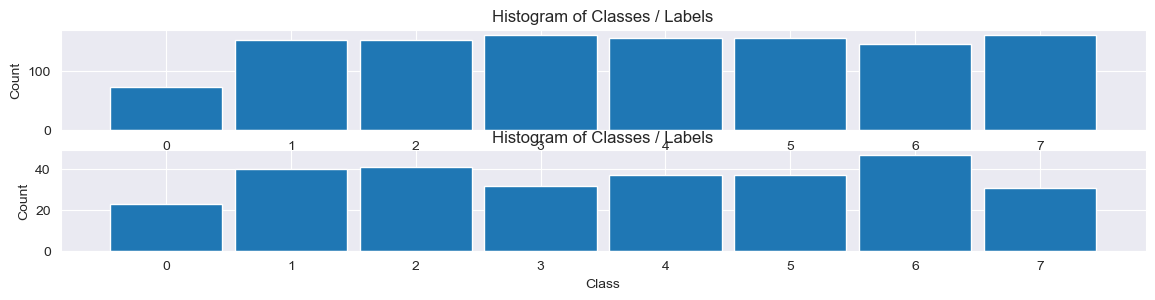

Train Data extrapulated with total 2073 samples collected with 14 features.
Test Data extrapulated with total 519 samples collected with 14 features.


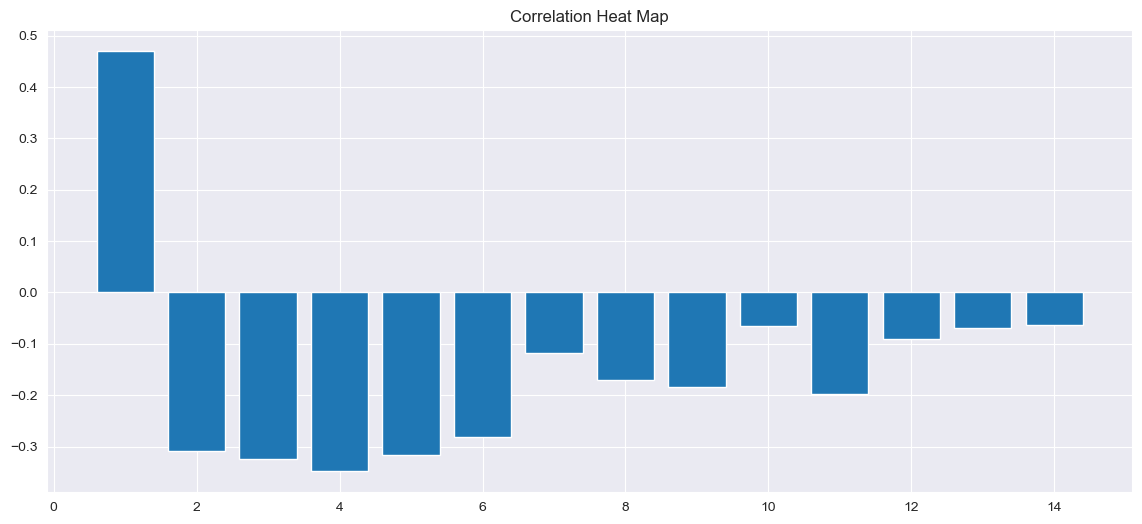

Prediction Train Accuracy: 99.90 %
Prediction Test Accuracy: 68.79 %
              precision    recall  f1-score   support

           0       0.75      0.13      0.22        23
           1       0.79      0.95      0.87       240
           2       0.61      0.54      0.57        41
           3       0.30      0.25      0.27        32
           4       0.88      0.57      0.69        37
           5       0.64      0.38      0.47        37
           6       0.59      0.28      0.38        47
           7       0.49      0.77      0.60        62

    accuracy                           0.69       519
   macro avg       0.63      0.48      0.51       519
weighted avg       0.69      0.69      0.66       519



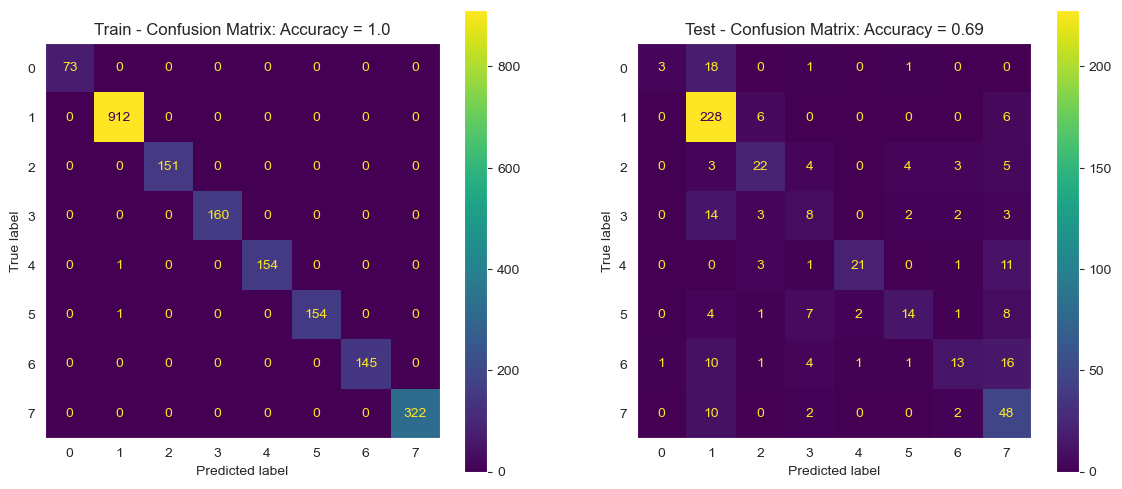

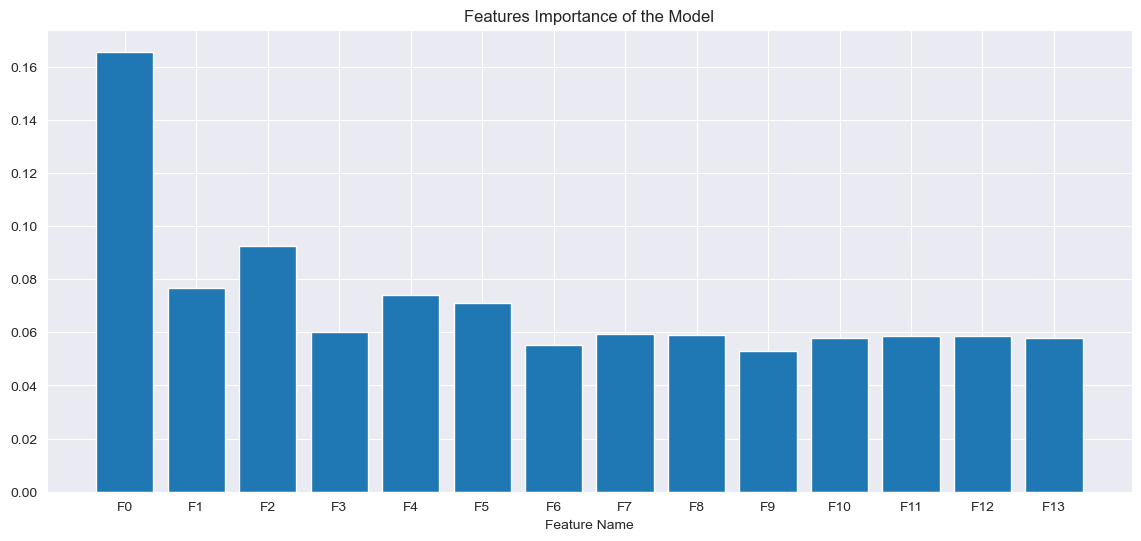

In [24]:
report, score, feature_importance, train_data,train_labels,test_data,test_labels = FeaturesTest(FRAME_LEN,HOP_LEN,N, plot=True)

6

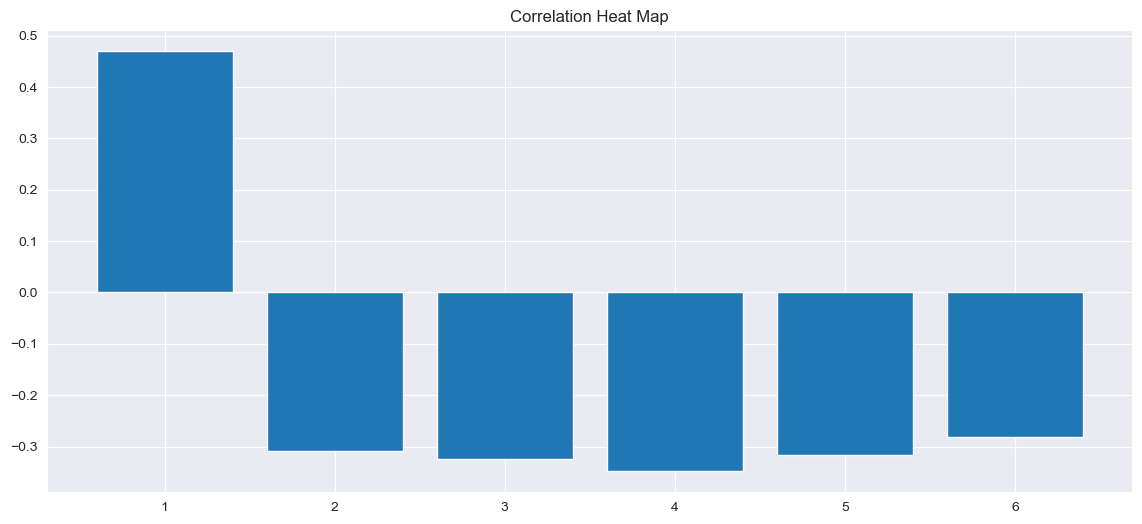

Prediction Train Accuracy: 99.32 %
Prediction Test Accuracy: 59.54 %
              precision    recall  f1-score   support

           0       0.11      0.04      0.06        23
           1       0.77      0.82      0.80       240
           2       0.46      0.44      0.45        41
           3       0.22      0.34      0.27        32
           4       0.59      0.46      0.52        37
           5       0.52      0.30      0.38        37
           6       0.47      0.19      0.27        47
           7       0.45      0.71      0.55        62

    accuracy                           0.60       519
   macro avg       0.45      0.41      0.41       519
weighted avg       0.59      0.60      0.58       519



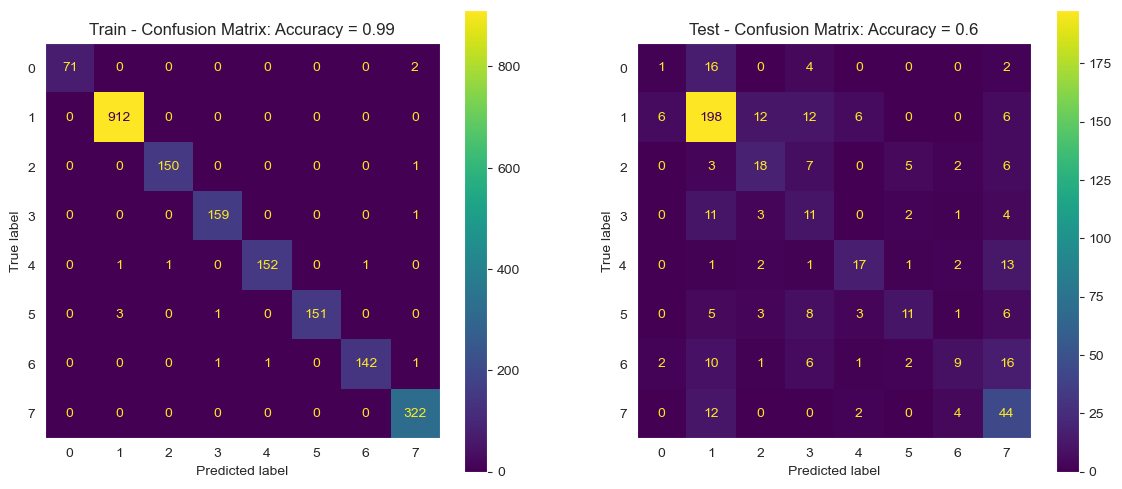

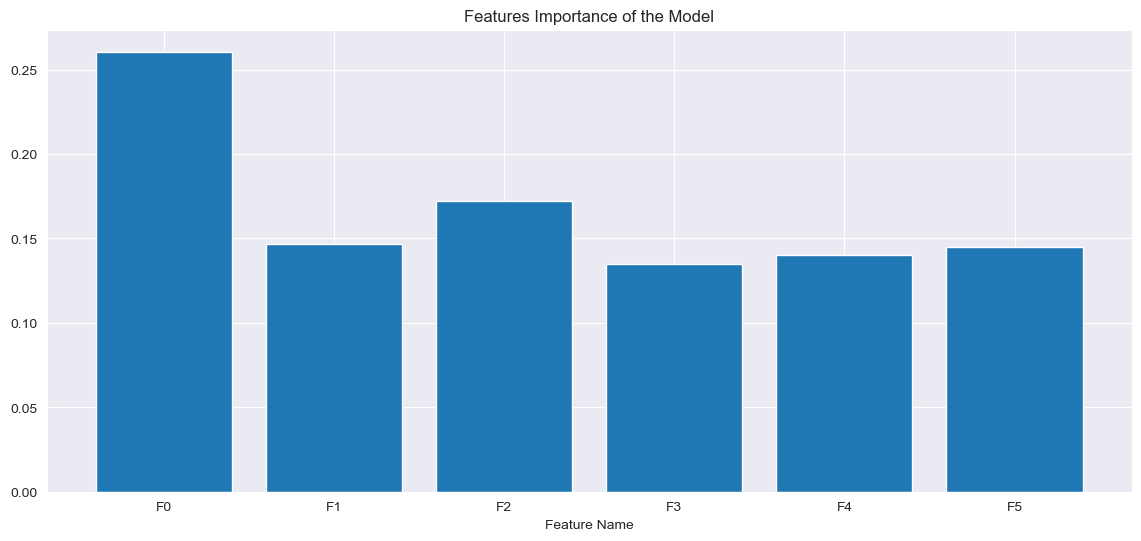

In [25]:
TestImportantFeatures(feature_importance,0.06,train_data,train_labels,test_data,test_labels)

## DEBUG

In [26]:
from sklearn.linear_model import lars_path, lasso_path

dfX = lib.Numpy2Pandas(train_data)
dsY = lib.Numpy2Pandas(train_labels.reshape(train_labels.shape[0],1))

# LASSO Path Analysis
alphasPath, coefsPath, *_ = lasso_path(dfX, dsY)
alphasPath = alphasPath.reshape(alphasPath.shape[0],1)
coefsPath = coefsPath[0,:,:]
display(alphasPath.shape)
display(coefsPath.shape)

# Display the LASSO Path
'''
hF, hA = plt.subplots(figsize = (16, 8))
hA.plot(alphasPath, np.abs(coefsPath.T), lw = 2, label = dfX.columns.to_list())
hA.set_title('The Lasso Path')
hA.set_xlabel('$\lambda$')
hA.set_ylabel('Coefficient Value (${w}_{i}$)')
hA.legend()
plt.show()
'''

_, _, coefs = lars_path(dfX, dsY, method="lasso", verbose=True)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle="dashed")
plt.xlabel("|coef| / max|coef|")
plt.ylabel("Coefficients")
plt.title("LASSO Path")
plt.axis("tight")
plt.show()

(100, 1)

(14, 100)

InvalidParameterError: The 'X' parameter of lars_path must be an instance of 'numpy.ndarray' or None. Got               F0         F1         F2         F3         F4         F5  \
0    -456.229706  45.137074   4.433401   6.481163  -2.732270   2.193209   
1    -371.938263  34.060173  -9.836699   4.157547 -11.602619 -12.033872   
2    -553.488831  61.639843  -1.894336  11.079434   4.902419  -1.457460   
3    -523.430420  72.330360  -9.145835  11.077016  11.921607  -2.276799   
4    -642.458008  44.895935   6.091766   9.234806   4.121640   1.292051   
...          ...        ...        ...        ...        ...        ...   
2068 -464.083496  25.828302 -15.102417  -6.816665  -4.379288  -7.762430   
2069 -497.741028  50.490685   1.360619   2.721259   0.309192   3.162795   
2070 -482.116913  46.675472  -9.882648  -1.999010   0.704728  -4.966242   
2071 -473.247314  59.020977  -2.413124  14.580596  11.595218   0.393801   
2072 -489.618408  60.023556   2.448477   8.395958   1.906347  -1.655299   

             F6         F7         F8        F9       F10        F11  \
0     -0.632380  -3.552397  -7.138731 -6.077223  2.287492  -3.714346   
1     -5.506781 -10.872380 -10.129924  2.745439 -9.462357  -2.998848   
2    -14.008227  -7.399913  -5.809836 -8.307908 -0.338911  -3.785078   
3     -1.522751  -4.180936  -8.076155  2.713225  2.623562   1.574878   
4     -7.092252  -7.111799  -6.911267 -1.462386 -2.162197  -7.161170   
...         ...        ...        ...       ...       ...        ...   
2068 -15.123044 -11.594645 -13.286707 -1.198682 -5.572973 -10.867878   
2069  -2.040218  -9.205647 -13.057741 -3.569070  2.822913  -2.121943   
2070  -8.184649  -8.674297 -10.585235 -4.043421 -1.117748  -3.928900   
2071   3.592892  -0.681905  -3.886974  3.948779  2.350001   0.895825   
2072  -7.105773 -11.038517  -4.739851  2.876167 -4.210572  -2.606280   

           F12        F13  
0    -0.987957  -1.028169  
1    -0.292141  -6.023686  
2    -3.460160   1.083892  
3    -3.135928   1.408036  
4     0.682814  -1.714408  
...        ...        ...  
2068 -4.577063 -10.825908  
2069 -2.000263  -2.713514  
2070 -6.303631  -4.437381  
2071  2.091367   1.435995  
2072  1.738052  -1.615719  

[2073 rows x 14 columns] instead.